In [1]:
# Code from: https://github.com/gokriznastic/HybridSN
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

import numba
from numba import jit

init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

import mypackage

TensorFlow version is 2.1.0


# Data Loading

In [3]:
## GLOBAL VARIABLES
dataset = 'HyperChicken'
test_ratio = 0.7
windowSize = 25

In [4]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'HyperChicken':
        print("loding stuff")
        data, labels, info = mypackage.Dataset.load("../../Code/data/tomra")
#         labels[labels == 3] = 2
#         labels[labels == 4] = 2
#         labels[labels == 5] = 2
#         labels = labels + 1
        data, labels = data[0], labels[0]
        data, labels = data[18:-18, 18:-18], labels[18:-18, 18:-18]
    
    return data, labels

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
X, y = loadData(dataset)

X.shape, y.shape

loding stuff


((64, 64, 208), (64, 64, 1))

In [10]:
np.unique(y)

array([1, 2, 3], dtype=int32)

In [11]:
K = X.shape[2]

In [12]:
# K = 30 if dataset == 'IP' or dataset == 'HyperChicken' else 15
# X,pca = applyPCA(X,numComponents=K)

# X.shape

In [13]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((4096, 25, 25, 208), (4096,))

In [14]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1228, 25, 25, 208), (2868, 25, 25, 208), (1228,), (2868,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [15]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(1228, 25, 25, 208, 1)

In [16]:
np.unique(ytrain)

array([0., 1., 2.])

In [17]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(1228, 3)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [18]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16
output_units = 3 if dataset == 'HyperChicken' else output_units

In [19]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 16), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 10), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 5), activation='relu')(conv_layer2)
################ Added by me ##########################################################
# The last dimensions in the kernel_sizes was 7, 5 and 3
conv_layer4 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
conv_layer3 = conv_layer4
#######################################################################################
print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3._keras_shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 17, 17, 178, 32)


In [20]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 208, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 193, 8)    1160      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 184, 16)   11536     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 180, 32)   23072     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 17, 17, 178, 32)   27680     
_________________________________________________________________
reshape_1 (Reshape)          (None, 17, 17, 5696)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        3280

In [22]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [23]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [24]:
Xtrain.shape, ytrain.shape

((1228, 25, 25, 208, 1), (1228, 3))

In [25]:
# import matplotlib.pyplot as plt
# plt.imshow(ytrain[0])

In [26]:
# Had batch_size=256
history = model.fit(x=Xtrain, y=ytrain, batch_size=10, epochs=25, callbacks=callbacks_list)

Epoch 1/25
1228/1228 [==============================] - 696s 566ms/step - loss: 1.2003 - accuracy: 0.6474

Epoch 00001: accuracy improved from -inf to 0.64739, saving model to best-model.hdf5
Epoch 2/25
1228/1228 [==============================] - 682s 556ms/step - loss: 0.6407 - accuracy: 0.6621

Epoch 00002: accuracy improved from 0.64739 to 0.66205, saving model to best-model.hdf5
Epoch 3/25
1228/1228 [==============================] - 681s 555ms/step - loss: 0.6042 - accuracy: 0.6629

Epoch 00003: accuracy improved from 0.66205 to 0.66287, saving model to best-model.hdf5
Epoch 4/25
1228/1228 [==============================] - 678s 552ms/step - loss: 0.6086 - accuracy: 0.6686

Epoch 00004: accuracy improved from 0.66287 to 0.66857, saving model to best-model.hdf5
Epoch 5/25
1228/1228 [==============================] - 678s 552ms/step - loss: 0.6088 - accuracy: 0.6694

Epoch 00005: accuracy improved from 0.66857 to 0.66938, saving model to best-model.hdf5
Epoch 6/25
1228/1228 [======

plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

# Validation

In [27]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [28]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(2868, 25, 25, 208, 1)

In [29]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(2868, 3)

In [30]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      1952
           1       0.00      0.00      0.00       839
           2       0.00      0.00      0.00        77

    accuracy                           0.68      2868
   macro avg       0.23      0.33      0.27      2868
weighted avg       0.46      0.68      0.55      2868



/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [31]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [32]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    elif name == 'HyperChicken':
        target_names = ['Belt','Meat','Plastic']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [33]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

2868/2868 [==============================] - 260s 91ms/step


In [34]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [35]:
# load the original image
X, y = loadData(dataset)

loding stuff


In [36]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [37]:
X,pca = applyPCA(X, numComponents=numComponents)

In [38]:
X = padWithZeros(X, PATCH_SIZE//2)

In [39]:
# calculate the predicted image
outputs = np.zeros((height,width))

# This for-loop needs to be move to a function inorder to optimize with numba
# @jit(nopython=True, parallel=True)
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

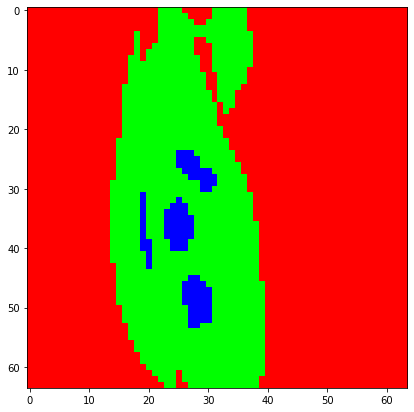

In [40]:
ground_truth = spectral.imshow(classes = np.squeeze(y),figsize =(7,7))

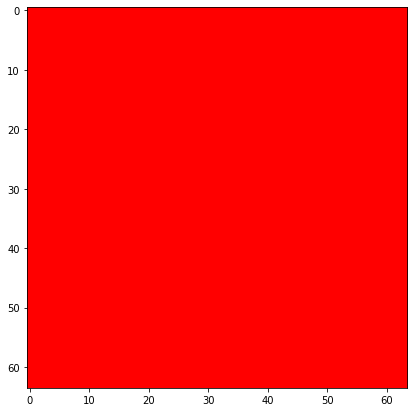

In [41]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

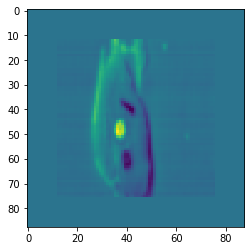

In [42]:
plt.figure()
plt.imshow(X[:, :, 1])

In [43]:
spectral.save_rgb("prediction_WithAll208.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)